# TODO:
    1. After running SVI, we have optimal value for variational parameters. How do we sample from q(z) without writing a new q function using this optimal values.

# Introduction

Model-based machine learning seperates model building and inference procedure. This enables running different inferences on the same model without a lot of modification.

There are different toolkits that enables implementation of machine learning algorithm using the model-based approach such as BUG[?], Tensorflow Probability[?], Pyro[?], Stan[?], etc. We will use Pyro/Pytorch due to its intuitive API.

Tensorflow probability is also a good choice since you can rely on tensorflow to deliver production-ready system. But it is rather painful for your eye to read tensorflow code. I find it hard to understand even my own code after a few weeks of writing them.

# Model

People build probablistic model to capture phenomena. This enables simulation to study the world. 

In [33]:
import torch
import pyro
import pyro.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
import warnings

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
torch.__version__, pyro.__version__

('1.0.1.post2', '0.3.0')

In [6]:
pyro.optim

<module 'pyro.optim' from '/Users/totucuong/miniconda3/envs/spectrumdev/lib/python3.6/site-packages/pyro/optim/__init__.py'>

We set random generator seed to make sure our result are reproducible.

In [7]:
pyro.set_rng_seed(101)

So a model is just an object that can be called, i.e., having ``__call__()`` that consists of primitive stochastic elements provided by Pyro as well as other models.

### Primitive stochastic elements
Primitive stochastic elements are distributions such as Normal, Bernoulli, or Poisson. These distributions provides two main function that we will use a lot: ``log_prob`` and ``rsample``.

In [8]:
loc = 0.
scale = 1.
normal = torch.distributions.Normal(loc, scale)

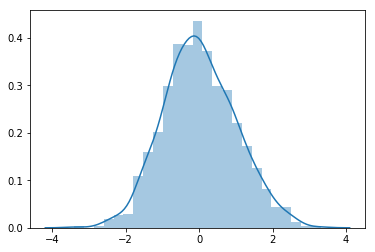

In [9]:
sns.distplot(normal.rsample((1000,)))

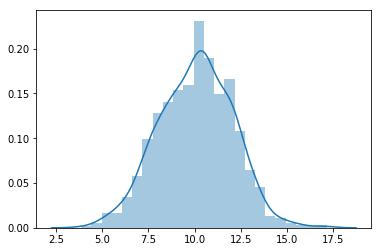

In [10]:
pyro_normal = pyro.distributions.Normal(loc=10., scale=2.)
sns.distplot(pyro_normal.rsample((1000,)))

In [11]:
pyro_normal = pyro.distributions.Normal

### Model from primitives

This model is copied from the Pyro documentation. Suppose that we want to reason about the relationship between temperatures and cloud cover. We may write a weather model as follows.

In [12]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()
    

In [13]:
temps = [weather()[1] for i in range(1000)]

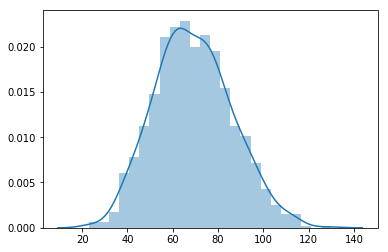

In [14]:
sns.distplot(temps)

This model is totally independent from Pyro. And hence we can not use Pyro facilities to perform different reasoning (inference) on this model. For this reason, we want to convert this model in to a Pyro model.

In [15]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 62.65092468261719)
('cloudy', 47.74857711791992)
('sunny', 75.75174713134766)


This new weather model still returns two samples. But because it use pyro.sample(), it nows define a joint distribution over two named rvs, ``cloudy``, and ``temp``.

Why do we need to use pyro.sample()? Because if we do this, Pyro provides inference algorithm that is able to answer questions such as What if I know the temperature is 70, what can I guess about the cloud cover?

In [16]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)


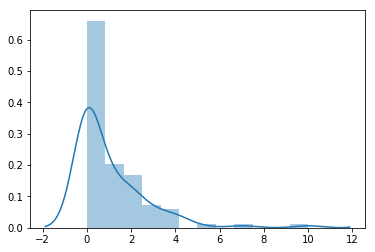

In [17]:
sns.distplot([geometric(0.45) for _ in range(100)])

Pyro is more powerful than this but for now let's just build some inferences. Without inferences, there is no fun.

# Inference

Since approximiate inference scales with large datasets (in the orders of millions data points), we will define a model and then use Pyro SVI.

Says, we have a list of weights of the same object from the same scale. This obviously shows that the scale is not that reliable. We want to build a model to reason about the scale's reliability.

To do this, we can integrate the noisy measurement with our initial guess. Since well, we may know about the objects based on its look its perceived density.

In [18]:
import pyro.distributions as dist

In [19]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample('measurement', dist.Normal(weight, 0.75))

In [20]:
measurements = [scale(100.) for _ in range(1000)]

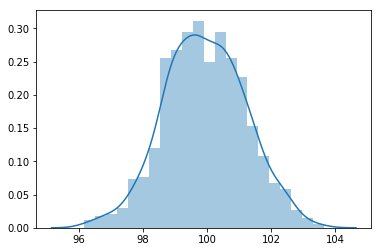

In [21]:
sns.distplot(measurements)

### Conditioning

We build model so that we can reason about unkown quantity (weight) given data (measurement and guess). This is called ``conditioning``.

In [22]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [23]:
measurements = [conditioned_scale(11) for _ in range(10)]

/Users/totucuong/miniconda3/envs/spectrumdev/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/totucuong/miniconda3/envs/spectrumdev/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


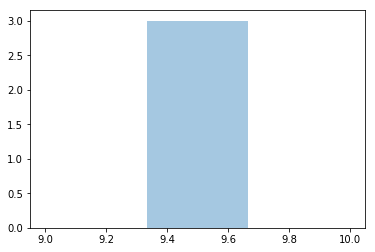

In [24]:
sns.distplot(measurements)

### Approximate Inference
Ok this section can be confusing for beginners. It helps to keep the following mapping in your head. Believe me even if you don't understand a thing at the moment. It will become as natural as the air you breath, with time.

- Guide functions -> variational distribution(VI) or proposal distribution (MCMC or Importance sampling)

In [25]:
import numpy as np

def perfect_guide(guess):
    """This is an analytic solution.
    http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf
    """
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

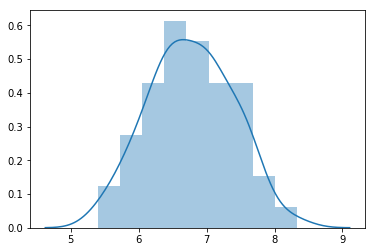

In [26]:
sns.distplot([perfect_guide(2) for _ in range(100)])

For most interesting models, we do not have an analytic solution for p(z|x). So people resolve to finding approximiate distribution q(z) such that to minimizing KL(q|p). Let's perform VI to find a good q(weight) for p(weight|guess, measurment=9.5)

Pyro implements stochastic variational inferneces using the following three characteristics:
    1. Parameters are real valued tensors
    2. MCMC estimates of loss function from samples executions histories of the model and guide
    3. We use stochastic gradient descent to search for optimal parameters

In [31]:
from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs


a =  0.617131769657135
b =  9.190735816955566


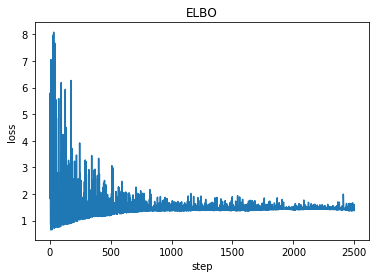

In [34]:

guess = torch.tensor(8.5)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("b").item())
print('b = ', pyro.param("a").item())

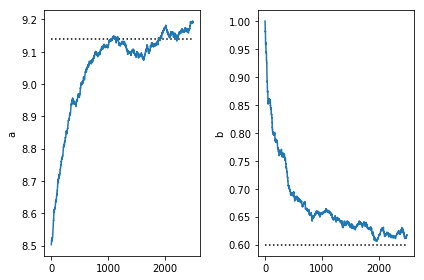

In [35]:

plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [36]:
pyro.param('a')

tensor(9.1907, requires_grad=True)

In [37]:
pyro.param('b')

tensor(0.6171, grad_fn=<AddBackward0>)

Let's plot the vi posterior q(weight)

In [42]:
def q_weight():
    return pyro.sample("weight", dist.Normal(pyro.param('a'), pyro.param('b')))

In [50]:
weight_samples = [q_weight().data for _ in range(1000)]

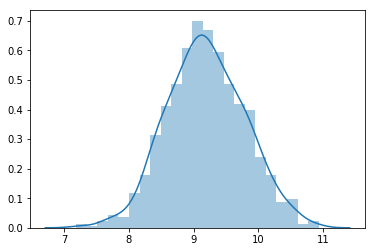

In [52]:
sns.distplot(weight_samples)